# Symmetry Breaking in the interaction terms

In this notebook, we have a look at the effect of symmetry breaking in the four interaction terms. For symmetry breaking in the angle, there are the following combinations
\begin{equation}
\begin{split}
    &V_0 \left(\cos\left(\phi+\frac{\pi}{4}+\delta\right)+\cos\left(\phi-\frac{\pi}{4}+\delta\right)+\cos\left(\phi+\frac{3\pi}{4}+\delta\right)+\cos\left(\phi-\frac{3\pi}{4}+\delta\right)\right), \\
    &V_0 \left(\cos\left(\phi+\frac{\pi}{4}-\delta\right)+\cos\left(\phi-\frac{\pi}{4}-\delta\right)+\cos\left(\phi+\frac{3\pi}{4}-\delta\right)+\cos\left(\phi-\frac{3\pi}{4}-\delta\right)\right), \\
    &V_0 \left(\cos\left(\phi+\frac{\pi}{4}+\delta\right)+\cos\left(\phi-\frac{\pi}{4}-\delta\right)+\cos\left(\phi+\frac{3\pi}{4}+\delta\right)+\cos\left(\phi-\frac{3\pi}{4}-\delta\right)\right), \\
    &V_0 \left(\cos\left(\phi+\frac{\pi}{4}+\delta\right)+\cos\left(\phi-\frac{\pi}{4}-\delta\right)+\cos\left(\phi+\frac{3\pi}{4}-\delta\right)+\cos\left(\phi-\frac{3\pi}{4}+\delta\right)\right), \\
    &\quad\quad\quad\quad\dots
\end{split}
\end{equation}
for some small $\delta$.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, gc

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [31]:
def visualize_angle_pattern(x, angle_pattern):
    pot_My1  = np.cos(x-0.25*np.pi+angle_pattern[0])
    pot_MyMx = np.cos(x-0.75*np.pi+angle_pattern[1])
    pot_11   = np.cos(x+0.25*np.pi+angle_pattern[2])
    pot_1Mx  = np.cos(x+0.75*np.pi+angle_pattern[3])

    fig, axs = plt.subplots(2,2, subplot_kw=dict(polar=True))

    axs[0, 0].plot(x, pot_MyMx, color='lightcoral')
    axs[0, 0].plot(x, np.cos(x-0.75*np.pi), color='lightblue')
    axs[0, 0].set_yticklabels([])
    axs[0, 0].set_xticklabels([])
    axs[0, 0].set_theta_zero_location('E')
    axs[0, 0].grid(linewidth=0.5)
    axs[0, 0].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    axs[0, 1].plot(x, pot_My1, color='lightcoral')
    axs[0, 1].plot(x, np.cos(x-0.25*np.pi), color='lightblue')
    axs[0, 1].set_yticklabels([])
    axs[0, 1].set_xticklabels([])
    axs[0, 1].set_theta_zero_location('E')
    axs[0, 1].grid(linewidth=0.5)
    axs[0, 1].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    axs[1, 0].plot(x, pot_1Mx, color='lightcoral')
    axs[1, 0].plot(x, np.cos(x+0.75*np.pi), color='lightblue')
    axs[1, 0].set_yticklabels([])
    axs[1, 0].set_xticklabels([])
    axs[1, 0].set_theta_zero_location('E')
    axs[1, 0].grid(linewidth=0.5)
    axs[1, 0].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    axs[1, 1].plot(x, pot_11, color='lightcoral')
    axs[1, 1].plot(x, np.cos(x+0.25*np.pi), color='lightblue')
    axs[1, 1].set_yticklabels([])
    axs[1, 1].set_xticklabels([])
    axs[1, 1].set_theta_zero_location('E')
    axs[1, 1].grid(linewidth=0.5)
    axs[1, 1].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    plt.show()

In [32]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [33]:
def solve_imag_time_prop(params):
    x = (2*np.pi/params["n"])*np.arange(params["n"])

    Mx = params["Mx"]
    My = params["My"]

    n = params["n"]

    tx = params["tx"]
    ty = params["ty"]

    B = params["B"]
    V_0 = params["V_0"]

    scale = B 

    exc_number = params["excitation_no"]

    wfn_manip = h_wavef.wavefunc_operations(params=params)
    wavefunc_object = h_wavef.wavefunctions(params=params)
    eom_object = eom.eom(params=params) 

    eom_object.V_0 = V_0
    wavefunc_object.V_0 = V_0 

    psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
    psi_init = wfn_manip.reshape_one_dim(psi_init)
        
    psi_0 = psi_init.copy() # for green function 

    # energy objects
    energy_object = energy.energy(params=params)
    overlap_object = energy.coupling_of_states(params=params) # needed for overlap calculations
        
    energy_object.V_0 = V_0
    overlap_object.V_0 = V_0

    in_object = h_in.imag_time(params=params)

    # lambda expression of right-hand-side of e.o.m
    func = eom_object.create_integration_function_imag_time_prop_sym_breaking_interaction() 

    iter = 0
    epsilon = 1 
    tol = params['tol']
    dt  = params['dt']
    E_converge_list = []
    while epsilon > tol:
        print('V_0 =', V_0, ', iter step = ' + str(iter+1))
            
        '''
        imag time evolution for dt
        '''
        sol = solve_ivp(func, [0,dt], psi_init, method='RK45', rtol=1e-9, atol=1e-9) # method='RK45','DOP853'

        '''
        normalize
        '''
        psi_iter = sol.y.T[-1]
        psi_iter = wfn_manip.normalize_wf(psi_iter, shape=(int(Mx*My),n))

        '''
        compute and save energy and epsilon criterion
        '''
        E = energy_object.calc_energy_sym_breaking(psi_iter)
        E_converge_list.append(E[0].real)
        epsilon = eom_object.epsilon_criterion_single_rotor(psi_iter, psi_init)
        print("E =", E[0].real, ", epsilon =", epsilon, "\n")

        '''
        update psi_init
        '''
        psi_init = wfn_manip.reshape_one_dim(psi_iter)
        iter = iter + 1

    psi_out = wfn_manip.reshape_three_dim(psi_init)
    return psi_out, E_converge_list

In [34]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0.1,0.1,0.1,0.1],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-12}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 

exc_number = params["excitation_no"]

### Create Reference Energy with no angle distortion

In [35]:
wavefunc_object = h_wavef.wavefunctions(params=params)    
wavefunc_object.V_0 = V_0 

psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
plot_rotor_wavefunction(x, My, Mx, psi_init.real)

Error in callback <function flush_figures at 0x7efe83352170> (for post_execute):


KeyboardInterrupt: 

## Lattice contractions in x direction
### 1st: asymmetric contraction

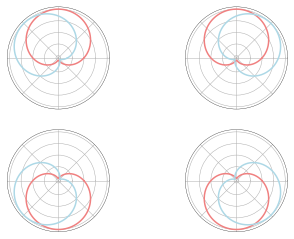

In [52]:
delta = np.pi/4 # np.pi/10
params["angle_pattern"] = [-delta,delta,delta,-delta]
params["init_choice"] = 'ferro_domain_horizontal_wall'
params["tol"] = 1e-7

'''
Visualize
'''
angle_pattern = np.array(params["angle_pattern"])
visualize_angle_pattern(x, angle_pattern)

V_0 = 130 , iter step = 1
E = -613.775913226787 , epsilon = 0.00017336877335460965 

V_0 = 130 , iter step = 2
E = -615.407986646695 , epsilon = 9.459161102864933e-05 

V_0 = 130 , iter step = 3
E = -616.3786267162277 , epsilon = 5.319099449707654e-05 

V_0 = 130 , iter step = 4
E = -616.9908828542846 , epsilon = 3.088844323839712e-05 

V_0 = 130 , iter step = 5
E = -617.3989180111613 , epsilon = 1.8527601667983618e-05 

V_0 = 130 , iter step = 6
E = -617.6840206247447 , epsilon = 1.1468604215192357e-05 

V_0 = 130 , iter step = 7
E = -617.8909319589196 , epsilon = 7.3131495957889925e-06 

V_0 = 130 , iter step = 8
E = -618.0454971047483 , epsilon = 4.792420527199859e-06 

V_0 = 130 , iter step = 9
E = -618.1634355549571 , epsilon = 3.218329106324802e-06 

V_0 = 130 , iter step = 10
E = -618.2548143799772 , epsilon = 2.315907644434567e-06 

V_0 = 130 , iter step = 11
E = -618.3263983558918 , epsilon = 1.9215792927962383e-06 

V_0 = 130 , iter step = 12
E = -618.3829272076166 , epsilon 

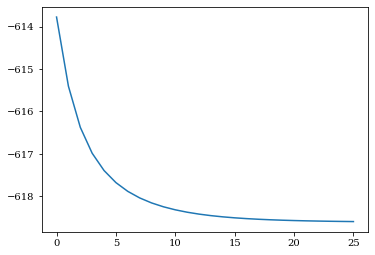

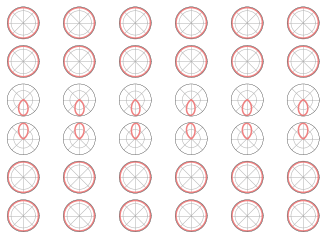

In [39]:
''' 
Time evolve
'''
psi_out_control, E_conv_control = solve_imag_time_prop(params)

plt.plot(E_conv_control)
plot_rotor_wavefunction(x, My, Mx, psi_out_control.real)

V_0 = 10 , iter step = 1
E = -177.80542119100411 , epsilon = 8.144633549922453e-06 

V_0 = 10 , iter step = 2
E = -178.0237454234475 , epsilon = 6.187614034258715e-06 

V_0 = 10 , iter step = 3
E = -178.22342078321802 , epsilon = 5.101950925068266e-06 

V_0 = 10 , iter step = 4
E = -178.41164023233023 , epsilon = 4.476376918804981e-06 

V_0 = 10 , iter step = 5
E = -178.5921672922836 , epsilon = 4.098041338718161e-06 

V_0 = 10 , iter step = 6
E = -178.76703678009633 , epsilon = 3.85526328383623e-06 

V_0 = 10 , iter step = 7
E = -178.93739648978274 , epsilon = 3.688552991931715e-06 

V_0 = 10 , iter step = 8
E = -179.1039292027946 , epsilon = 3.5656873691447544e-06 

V_0 = 10 , iter step = 9
E = -179.26706740889915 , epsilon = 3.468890325430962e-06 

V_0 = 10 , iter step = 10
E = -179.427104402483 , epsilon = 3.3881584892148098e-06 

V_0 = 10 , iter step = 11
E = -179.58425290392742 , epsilon = 3.317739943664577e-06 

V_0 = 10 , iter step = 12
E = -179.73867673199396 , epsilon = 3.254

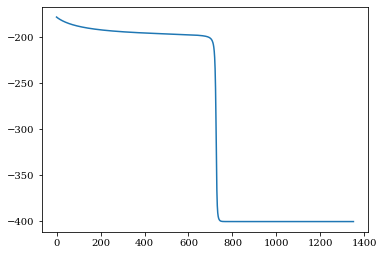

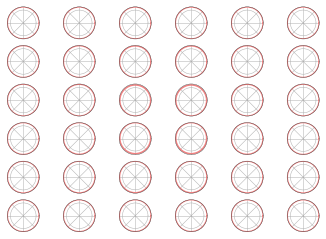

V_0 = 10 , iter step = 1
E = -400.2780865657164 , epsilon = 1.7068916949303237e-05 

V_0 = 10 , iter step = 2
E = -400.4125376561268 , epsilon = 7.957446013007186e-06 

V_0 = 10 , iter step = 3
E = -400.48298006098645 , epsilon = 3.8629008336510395e-06 

V_0 = 10 , iter step = 4
E = -400.5228862192423 , epsilon = 1.9526084795717935e-06 

V_0 = 10 , iter step = 5
E = -400.54720156756116 , epsilon = 1.0274608617244496e-06 

V_0 = 10 , iter step = 6
E = -400.56300074883666 , epsilon = 5.625152555976953e-07 

V_0 = 10 , iter step = 7
E = -400.57383172203396 , epsilon = 3.201422146270616e-07 

V_0 = 10 , iter step = 8
E = -400.5815798755912 , epsilon = 1.8916186761419596e-07 

V_0 = 10 , iter step = 9
E = -400.5873067999898 , epsilon = 1.3324924397206672e-07 

V_0 = 10 , iter step = 10
E = -400.5916449949728 , epsilon = 1.044027256869029e-07 

V_0 = 10 , iter step = 11
E = -400.5949918946395 , epsilon = 8.140769125475344e-08 

V_0 = 10 , iter step = 12
E = -400.5976094972094 , epsilon = 6.3

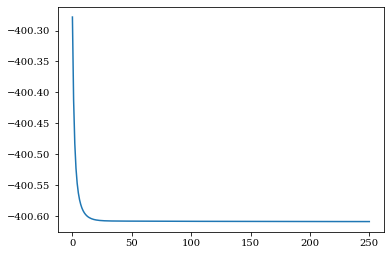

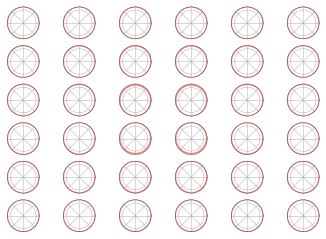

V_0 = 50 , iter step = 1
E = -179.51047957431007 , epsilon = 0.00011360655978620571 

V_0 = 50 , iter step = 2
E = -180.72273990275218 , epsilon = 6.632927957883616e-05 

V_0 = 50 , iter step = 3
E = -181.5425633025676 , epsilon = 4.0851248643725135e-05 

V_0 = 50 , iter step = 4
E = -182.14735588731855 , epsilon = 2.679602926791702e-05 

V_0 = 50 , iter step = 5
E = -182.62859132040805 , epsilon = 1.8822505666316047e-05 

V_0 = 50 , iter step = 6
E = -183.03480568286292 , epsilon = 1.4153939722039155e-05 

V_0 = 50 , iter step = 7
E = -183.39266930294787 , epsilon = 1.1323010993935512e-05 

V_0 = 50 , iter step = 8
E = -183.71745350141072 , epsilon = 9.539306361716626e-06 

V_0 = 50 , iter step = 9
E = -184.01832161689336 , epsilon = 8.368153598947714e-06 

V_0 = 50 , iter step = 10
E = -184.30105755371955 , epsilon = 7.565289842581535e-06 

V_0 = 50 , iter step = 11
E = -184.56950450258017 , epsilon = 6.990346434365691e-06 

V_0 = 50 , iter step = 12
E = -184.8263428973039 , epsilon 

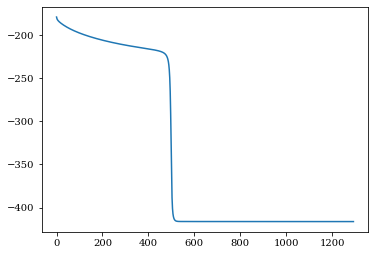

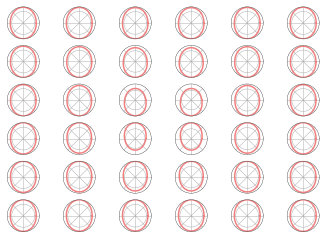

V_0 = 50 , iter step = 1
E = -406.9503908907488 , epsilon = 0.0004265620210575083 

V_0 = 50 , iter step = 2
E = -410.3178181509137 , epsilon = 0.00019941922391208955 

V_0 = 50 , iter step = 3
E = -412.09905596200605 , epsilon = 9.802942696623962e-05 

V_0 = 50 , iter step = 4
E = -413.1243727418653 , epsilon = 5.0736361355774307e-05 

V_0 = 50 , iter step = 5
E = -413.7613231536502 , epsilon = 2.761749963564597e-05 

V_0 = 50 , iter step = 6
E = -414.18376828777974 , epsilon = 1.578480443753527e-05 

V_0 = 50 , iter step = 7
E = -414.4794427344352 , epsilon = 9.45543558228401e-06 

V_0 = 50 , iter step = 8
E = -414.69545448419103 , epsilon = 5.9236648006777415e-06 

V_0 = 50 , iter step = 9
E = -414.85863936291923 , epsilon = 3.871500803387384e-06 

V_0 = 50 , iter step = 10
E = -414.98516026790674 , epsilon = 2.717801545149001e-06 

V_0 = 50 , iter step = 11
E = -415.08526416483016 , epsilon = 2.167562407562329e-06 

V_0 = 50 , iter step = 12
E = -415.1657529467284 , epsilon = 1.728

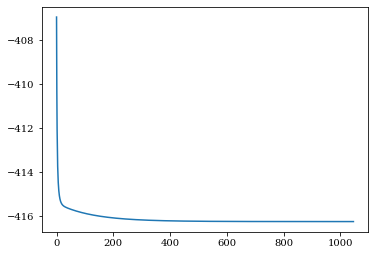

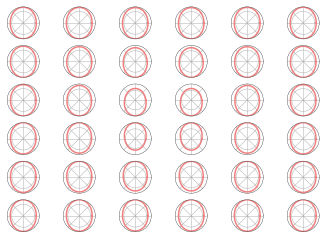

V_0 = 90 , iter step = 1
E = -183.4905854050553 , epsilon = 0.00035974819763318067 

V_0 = 90 , iter step = 2
E = -187.03746096458042 , epsilon = 0.00020767358163653604 

V_0 = 90 , iter step = 3
E = -189.3401109211773 , epsilon = 0.00012665526609567657 

V_0 = 90 , iter step = 4
E = -190.96929313825189 , epsilon = 8.236149408613613e-05 

V_0 = 90 , iter step = 5
E = -192.2153761554128 , epsilon = 5.732993627161065e-05 

V_0 = 90 , iter step = 6
E = -193.23108483138327 , epsilon = 4.265754410925915e-05 

V_0 = 90 , iter step = 7
E = -194.1000333611391 , epsilon = 3.3718690964024134e-05 

V_0 = 90 , iter step = 8
E = -194.87009563866718 , epsilon = 2.804998320027341e-05 

V_0 = 90 , iter step = 9
E = -195.5700392328229 , epsilon = 2.4304405576991428e-05 

V_0 = 90 , iter step = 10
E = -196.21804182498846 , epsilon = 2.1725493890345504e-05 

V_0 = 90 , iter step = 11
E = -196.82617645846295 , epsilon = 1.987702943306857e-05 

V_0 = 90 , iter step = 12
E = -197.40284478889583 , epsilon = 

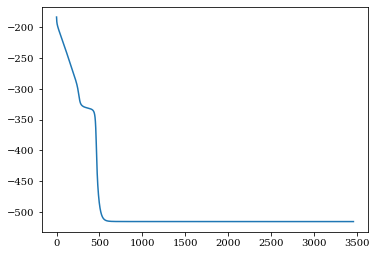

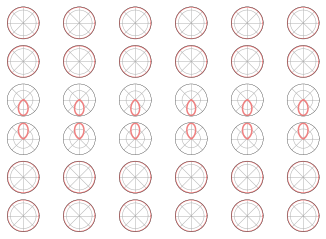

V_0 = 90 , iter step = 1
E = -422.5057652136175 , epsilon = 0.001380837078375441 

V_0 = 90 , iter step = 2
E = -433.46102461501414 , epsilon = 0.0006496423800765871 

V_0 = 90 , iter step = 3
E = -439.38206146595195 , epsilon = 0.00032842344785155575 

V_0 = 90 , iter step = 4
E = -442.9143650679942 , epsilon = 0.00017898051661324743 

V_0 = 90 , iter step = 5
E = -445.20595125251305 , epsilon = 0.00010465889629318603 

V_0 = 90 , iter step = 6
E = -446.79721647613013 , epsilon = 6.523884797648982e-05 

V_0 = 90 , iter step = 7
E = -447.9632977556607 , epsilon = 4.3049176857046234e-05 

V_0 = 90 , iter step = 8
E = -448.85463447551996 , epsilon = 2.98613580661522e-05 

V_0 = 90 , iter step = 9
E = -449.5588864050092 , epsilon = 2.1627134469182074e-05 

V_0 = 90 , iter step = 10
E = -450.1300854742913 , epsilon = 1.6251593393468156e-05 

V_0 = 90 , iter step = 11
E = -450.6032186185476 , epsilon = 1.2599332385510031e-05 

V_0 = 90 , iter step = 12
E = -451.00193327707814 , epsilon = 1.

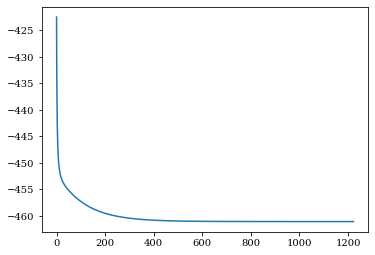

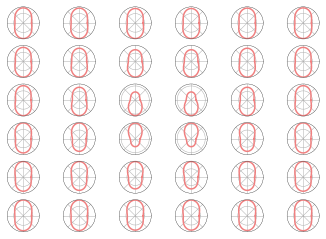

V_0 = 130 , iter step = 1
E = -189.7496516076967 , epsilon = 0.0007467216044523273 

V_0 = 130 , iter step = 2
E = -197.00874239481175 , epsilon = 0.0004326431913597162 

V_0 = 130 , iter step = 3
E = -201.74346012956397 , epsilon = 0.00026828186540250876 

V_0 = 130 , iter step = 4
E = -205.13423401444732 , epsilon = 0.0001797839548026703 

V_0 = 130 , iter step = 5
E = -207.77016983816458 , epsilon = 0.0001302192597227858 

V_0 = 130 , iter step = 6
E = -209.95722543849715 , epsilon = 0.00010126372797447658 

V_0 = 130 , iter step = 7
E = -211.86204344650292 , epsilon = 8.362301097641911e-05 

V_0 = 130 , iter step = 8
E = -213.58011294595894 , epsilon = 7.24322313386816e-05 

V_0 = 130 , iter step = 9
E = -215.16907745554502 , epsilon = 6.505840034387589e-05 

V_0 = 130 , iter step = 10
E = -216.66559368373962 , epsilon = 6.0028884981910835e-05 

V_0 = 130 , iter step = 11
E = -218.0941761704614 , epsilon = 5.649363691095921e-05 

V_0 = 130 , iter step = 12
E = -219.4720060503405 , 

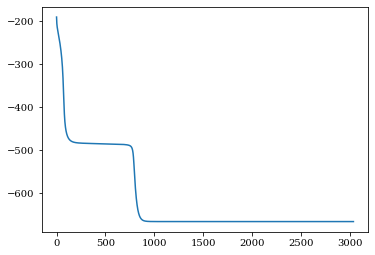

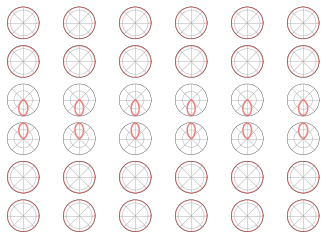

V_0 = 130 , iter step = 1
E = -446.91170051670684 , epsilon = 0.002876958925082329 

V_0 = 130 , iter step = 2
E = -469.905727489277 , epsilon = 0.0013662271092584888 

V_0 = 130 , iter step = 3
E = -482.73237163953934 , epsilon = 0.0007192919815982579 

V_0 = 130 , iter step = 4
E = -490.7912587586593 , epsilon = 0.0004211792834054595 

V_0 = 130 , iter step = 5
E = -496.3580892424807 , epsilon = 0.00027081647799320763 

V_0 = 130 , iter step = 6
E = -500.4910801386549 , epsilon = 0.00018821629328769074 

V_0 = 130 , iter step = 7
E = -503.73060233353544 , epsilon = 0.0001392708359512218 

V_0 = 130 , iter step = 8
E = -506.3762116240697 , epsilon = 0.00010830291438557182 

V_0 = 130 , iter step = 9
E = -508.60605532260496 , epsilon = 8.75846029796401e-05 

V_0 = 130 , iter step = 10
E = -510.5325786611787 , epsilon = 7.305841236471267e-05 

V_0 = 130 , iter step = 11
E = -512.2304152577422 , epsilon = 6.246997655479092e-05 

V_0 = 130 , iter step = 12
E = -513.7512485842852 , epsilon

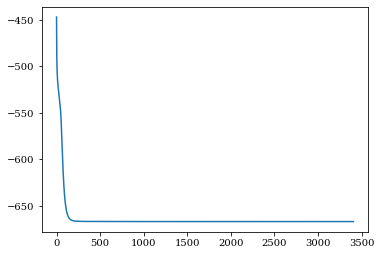

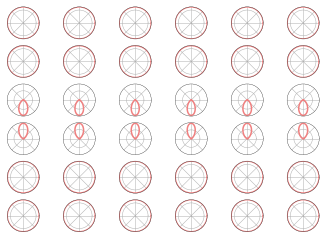

V_0 = 170 , iter step = 1
E = -198.29378821125198 , epsilon = 0.0012747628650000564 

V_0 = 170 , iter step = 2
E = -210.7003683291234 , epsilon = 0.0007450143706113632 

V_0 = 170 , iter step = 3
E = -218.95397397237855 , epsilon = 0.0004748795492945934 

V_0 = 170 , iter step = 4
E = -225.05691593037312 , epsilon = 0.00033325998601108076 

V_0 = 170 , iter step = 5
E = -229.9869483053897 , epsilon = 0.00025596719464759943 

V_0 = 170 , iter step = 6
E = -234.24557906934646 , epsilon = 0.00021215666991813986 

V_0 = 170 , iter step = 7
E = -238.10574932107892 , epsilon = 0.00018662881273623366 

V_0 = 170 , iter step = 8
E = -241.72570686503514 , epsilon = 0.00017160872620425316 

V_0 = 170 , iter step = 9
E = -245.20343526499747 , epsilon = 0.00016296475351129658 

V_0 = 170 , iter step = 10
E = -248.6038545182658 , epsilon = 0.00015842460145254478 

V_0 = 170 , iter step = 11
E = -251.9730462141684 , epsilon = 0.00015670366306252959 

V_0 = 170 , iter step = 12
E = -255.346041865703

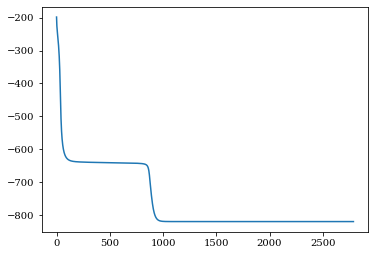

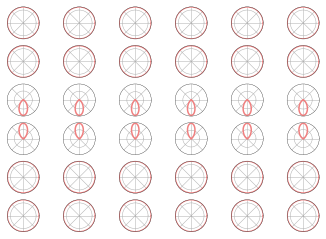

V_0 = 170 , iter step = 1
E = -480.1157080430216 , epsilon = 0.004910221074622689 

V_0 = 170 , iter step = 2
E = -519.721414161799 , epsilon = 0.0023589744272405344 

V_0 = 170 , iter step = 3
E = -542.6850613178025 , epsilon = 0.0013040768715900652 

V_0 = 170 , iter step = 4
E = -558.029732084418 , epsilon = 0.0008283257791530385 

V_0 = 170 , iter step = 5
E = -569.4377856034528 , epsilon = 0.000589163223380762 

V_0 = 170 , iter step = 6
E = -578.5983062670036 , epsilon = 0.0004567663512813347 

V_0 = 170 , iter step = 7
E = -586.3763825720753 , epsilon = 0.00037755421219576313 

V_0 = 170 , iter step = 8
E = -593.2598922369416 , epsilon = 0.0003273175106712767 

V_0 = 170 , iter step = 9
E = -599.547869409052 , epsilon = 0.0002941713702229176 

V_0 = 170 , iter step = 10
E = -605.4372612776004 , epsilon = 0.00027182632119748806 

V_0 = 170 , iter step = 11
E = -611.0659584262313 , epsilon = 0.0002567097170063093 

V_0 = 170 , iter step = 12
E = -616.5353738217495 , epsilon = 0.00

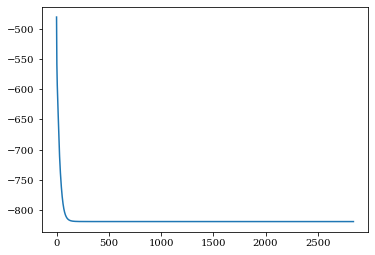

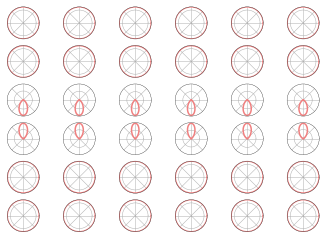

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


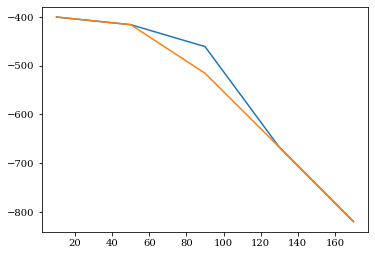

In [58]:
V_0_scan = np.array([10,50,90,130,170])
params["tol"] = 1e-11

E_domain_wall = np.zeros(len(V_0_scan), dtype=complex)
E_ferro_order = np.zeros(len(V_0_scan), dtype=complex)

i = 0
for V_0 in V_0_scan:
    
    params["V_0"] = V_0

    ''' 
    Time evolve domain wall
    '''
    params["init_choice"] = 'ferro_domain_horizontal_wall'
    psi_out_control, E_conv_control_ferro_domain = solve_imag_time_prop(params)

    plt.plot(E_conv_control_ferro_domain); plt.show()
    plot_rotor_wavefunction(x, My, Mx, psi_out_control.real); plt.show()

    ''' 
    Time evolve ferro order
    '''
    params["init_choice"] = 'uniform'
    psi_out_control, E_conv_control_ferro_order = solve_imag_time_prop(params)

    plt.plot(E_conv_control_ferro_order); plt.show()
    plot_rotor_wavefunction(x, My, Mx, psi_out_control.real); plt.show()

    E_domain_wall[i] = E_conv_control_ferro_domain[-1]
    E_ferro_order[i] = E_conv_control_ferro_order[-1]

    i += 1

plt.plot(V_0_scan, E_ferro_order)
plt.plot(V_0_scan, E_domain_wall)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


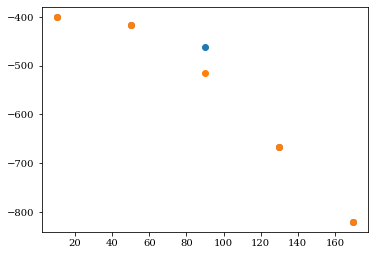

In [59]:
plt.scatter(V_0_scan, E_ferro_order)
plt.scatter(V_0_scan, E_domain_wall)

### Scan through the $\delta$ range

V_0 = 130 , iter step = 1
E = -527.5818909050641 , epsilon = 0.00037319654379186495 

V_0 = 130 , iter step = 2
E = -530.9620073803558 , epsilon = 0.00019942020789309733 

V_0 = 130 , iter step = 3
E = -532.9387518284097 , epsilon = 0.0001098572698848832 

V_0 = 130 , iter step = 4
E = -534.1751864039848 , epsilon = 6.26296879993049e-05 

V_0 = 130 , iter step = 5
E = -535.0013609833265 , epsilon = 3.7018462161197974e-05 

V_0 = 130 , iter step = 6
E = -535.5873875653984 , epsilon = 2.2721551838911225e-05 

V_0 = 130 , iter step = 7
E = -536.0246297679546 , epsilon = 1.4509604253087893e-05 

V_0 = 130 , iter step = 8
E = -536.3644416566208 , epsilon = 9.659762784330894e-06 

V_0 = 130 , iter step = 9
E = -536.6371311964209 , epsilon = 7.773188101967143e-06 

V_0 = 130 , iter step = 10
E = -536.8615114418537 , epsilon = 6.750615110906466e-06 

V_0 = 130 , iter step = 11
E = -537.0498564438378 , epsilon = 5.834106074686929e-06 

V_0 = 130 , iter step = 12
E = -537.2105542641958 , epsilon

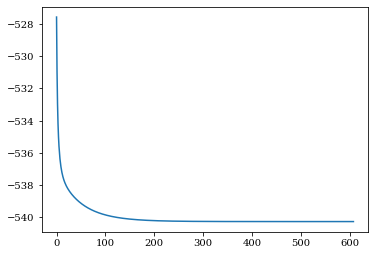

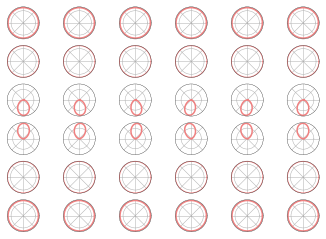

V_0 = 130 , iter step = 1
E = -527.5818909050645 , epsilon = 0.00037319654379186495 

V_0 = 130 , iter step = 2
E = -530.9620073834127 , epsilon = 0.00019942020840235664 

V_0 = 130 , iter step = 3
E = -532.9387518297679 , epsilon = 0.00010985726975154542 

V_0 = 130 , iter step = 4
E = -534.1751864045779 , epsilon = 6.262968793202539e-05 

V_0 = 130 , iter step = 5
E = -535.0013609835851 , epsilon = 3.701846212833537e-05 

V_0 = 130 , iter step = 6
E = -535.5873875655111 , epsilon = 2.2721551822924013e-05 

V_0 = 130 , iter step = 7
E = -536.0246297680064 , epsilon = 1.4509604245427354e-05 

V_0 = 130 , iter step = 8
E = -536.3644416566464 , epsilon = 9.659762780556136e-06 

V_0 = 130 , iter step = 9
E = -536.6371311964331 , epsilon = 7.773188103077366e-06 

V_0 = 130 , iter step = 10
E = -536.8615114418595 , epsilon = 6.750615111683622e-06 

V_0 = 130 , iter step = 11
E = -537.0498564438399 , epsilon = 5.834106075131018e-06 

V_0 = 130 , iter step = 12
E = -537.2105542641941 , epsilo

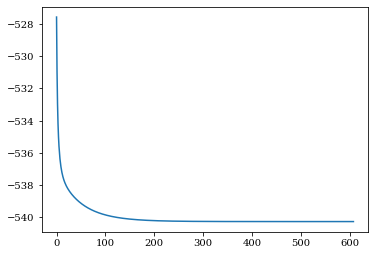

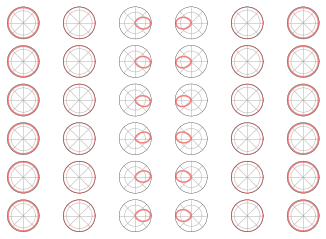

V_0 = 130 , iter step = 1
E = -446.86764794425346 , epsilon = 0.0028742614561945157 

V_0 = 130 , iter step = 2
E = -469.5540858758404 , epsilon = 0.0013468713910042007 

V_0 = 130 , iter step = 3
E = -481.7637456416047 , epsilon = 0.0006812481548521543 

V_0 = 130 , iter step = 4
E = -488.9948854044729 , epsilon = 0.0003713243687245571 

V_0 = 130 , iter step = 5
E = -493.61969105698347 , epsilon = 0.00021559936718984485 

V_0 = 130 , iter step = 6
E = -496.76087458353254 , epsilon = 0.000131854622421268 

V_0 = 130 , iter step = 7
E = -498.9968875964743 , epsilon = 8.416738018091063e-05 

V_0 = 130 , iter step = 8
E = -500.6482433300034 , epsilon = 5.56844029759862e-05 

V_0 = 130 , iter step = 9
E = -501.9037886146117 , epsilon = 3.797560273155476e-05 

V_0 = 130 , iter step = 10
E = -502.8807386845492 , epsilon = 2.658370104657859e-05 

V_0 = 130 , iter step = 11
E = -503.65515186894635 , epsilon = 1.9037205914895772e-05 

V_0 = 130 , iter step = 12
E = -504.2782991009985 , epsilon

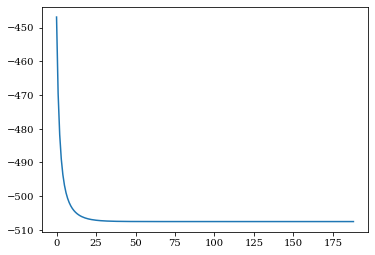

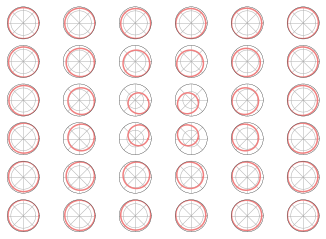

V_0 = 130 , iter step = 1
E = -585.943294272955 , epsilon = 0.00024251374886063992 

V_0 = 130 , iter step = 2
E = -588.1685101228987 , epsilon = 0.00013013590532817698 

V_0 = 130 , iter step = 3
E = -589.4706300742715 , epsilon = 7.177915601108698e-05 

V_0 = 130 , iter step = 4
E = -590.2806675088943 , epsilon = 4.0780170573184726e-05 

V_0 = 130 , iter step = 5
E = -590.8152602437076 , epsilon = 2.3870246068757872e-05 

V_0 = 130 , iter step = 6
E = -591.1870990352784 , epsilon = 1.4387863650489052e-05 

V_0 = 130 , iter step = 7
E = -591.4572580671291 , epsilon = 8.922455777105043e-06 

V_0 = 130 , iter step = 8
E = -591.660404251198 , epsilon = 5.686706307295175e-06 

V_0 = 130 , iter step = 9
E = -591.8172245437346 , epsilon = 4.314369622560044e-06 

V_0 = 130 , iter step = 10
E = -591.9407146898637 , epsilon = 3.652249005003938e-06 

V_0 = 130 , iter step = 11
E = -592.039454150967 , epsilon = 3.06587401710523e-06 

V_0 = 130 , iter step = 12
E = -592.119366438716 , epsilon = 2

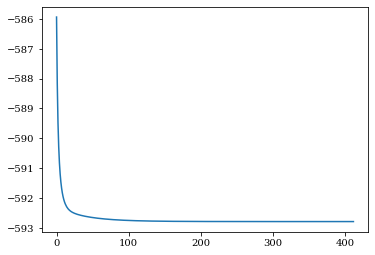

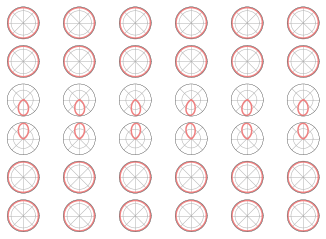

V_0 = 130 , iter step = 1
E = -456.0528849236891 , epsilon = 0.0005068739969429359 

V_0 = 130 , iter step = 2
E = -460.6726521466467 , epsilon = 0.0002738942857658522 

V_0 = 130 , iter step = 3
E = -463.4227587160084 , epsilon = 0.0001538709187415277 

V_0 = 130 , iter step = 4
E = -465.1876830614372 , epsilon = 9.047944050832868e-05 

V_0 = 130 , iter step = 5
E = -466.40598429413603 , epsilon = 5.590939417854379e-05 

V_0 = 130 , iter step = 6
E = -467.30324952746383 , epsilon = 3.641180551683387e-05 

V_0 = 130 , iter step = 7
E = -468.00062958610766 , epsilon = 2.50387160065646e-05 

V_0 = 130 , iter step = 8
E = -468.5662961410233 , epsilon = 1.8178827144499365e-05 

V_0 = 130 , iter step = 9
E = -469.0405374400997 , epsilon = 1.3899899220515266e-05 

V_0 = 130 , iter step = 10
E = -469.44838770804904 , epsilon = 1.1138691817569324e-05 

V_0 = 130 , iter step = 11
E = -469.80618989277946 , epsilon = 9.762792077427918e-06 

V_0 = 130 , iter step = 12
E = -470.1251185743592 , epsi

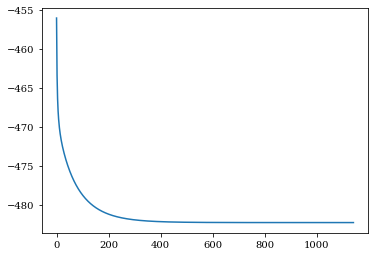

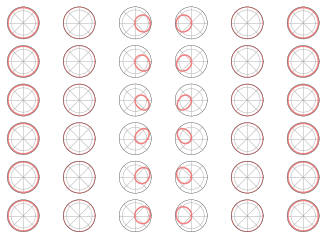

V_0 = 130 , iter step = 1
E = -446.8740993664983 , epsilon = 0.0028746564952114584 

V_0 = 130 , iter step = 2
E = -469.605590553302 , epsilon = 0.0013497064903795764 

V_0 = 130 , iter step = 3
E = -481.9056663000504 , epsilon = 0.0006868238750056266 

V_0 = 130 , iter step = 4
E = -489.25817463377325 , epsilon = 0.00037863697023710063 

V_0 = 130 , iter step = 5
E = -494.02108981947424 , epsilon = 0.00022370074729682887 

V_0 = 130 , iter step = 6
E = -497.3074708538099 , epsilon = 0.00014011510594713616 

V_0 = 130 , iter step = 7
E = -499.6899198585328 , epsilon = 9.221836144224227e-05 

V_0 = 130 , iter step = 8
E = -501.4856072623248 , epsilon = 6.332900678818199e-05 

V_0 = 130 , iter step = 9
E = -502.88157641993047 , epsilon = 4.512206804885288e-05 

V_0 = 130 , iter step = 10
E = -503.9941580632087 , epsilon = 3.3202309537183616e-05 

V_0 = 130 , iter step = 11
E = -504.8990648314928 , epsilon = 2.5133654264930527e-05 

V_0 = 130 , iter step = 12
E = -505.64753121889447 , eps

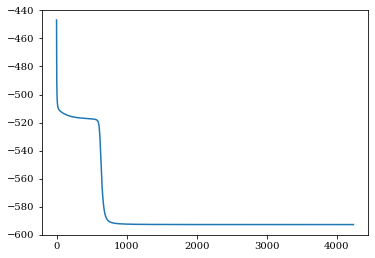

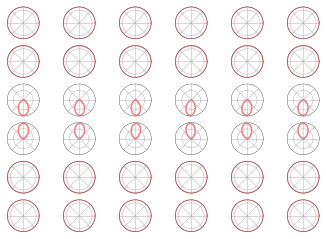

V_0 = 130 , iter step = 1
E = -629.1141581288382 , epsilon = 0.0001333841597800367 

V_0 = 130 , iter step = 2
E = -630.4082096225902 , epsilon = 7.434784589233079e-05 

V_0 = 130 , iter step = 3
E = -631.1942042558053 , epsilon = 4.287472008979165e-05 

V_0 = 130 , iter step = 4
E = -631.6996998129076 , epsilon = 2.5626457339278375e-05 

V_0 = 130 , iter step = 5
E = -632.0420204416093 , epsilon = 1.5873835994217877e-05 

V_0 = 130 , iter step = 6
E = -632.2840154003821 , epsilon = 1.0174669105134093e-05 

V_0 = 130 , iter step = 7
E = -632.4609132901529 , epsilon = 6.731048545205454e-06 

V_0 = 130 , iter step = 8
E = -632.593479725748 , epsilon = 4.5808384561141224e-06 

V_0 = 130 , iter step = 9
E = -632.694612959042 , epsilon = 3.195510565490167e-06 

V_0 = 130 , iter step = 10
E = -632.7727410379963 , epsilon = 2.2766657965522796e-06 

V_0 = 130 , iter step = 11
E = -632.8336277333826 , epsilon = 1.6510174296602287e-06 

V_0 = 130 , iter step = 12
E = -632.8813683071911 , epsilon

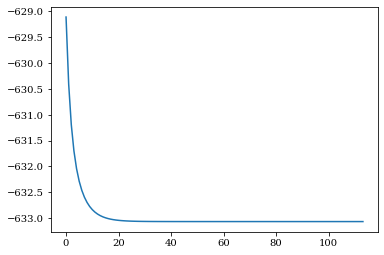

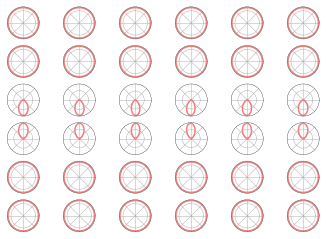

V_0 = 130 , iter step = 1
E = -373.8767231125901 , epsilon = 0.000624325489140265 

V_0 = 130 , iter step = 2
E = -379.66068448241685 , epsilon = 0.0003439211678681886 

V_0 = 130 , iter step = 3
E = -383.19798819684877 , epsilon = 0.00019901985466164174 

V_0 = 130 , iter step = 4
E = -385.5484797983588 , epsilon = 0.00012208958685255844 

V_0 = 130 , iter step = 5
E = -387.2373349711199 , epsilon = 7.974576201719152e-05 

V_0 = 130 , iter step = 6
E = -388.53499328046405 , epsilon = 5.552356493432331e-05 

V_0 = 130 , iter step = 7
E = -389.5871536734323 , epsilon = 4.111678762597215e-05 

V_0 = 130 , iter step = 8
E = -390.4761904549603 , epsilon = 3.220649039925583e-05 

V_0 = 130 , iter step = 9
E = -391.2510570484278 , epsilon = 2.6475267224657095e-05 

V_0 = 130 , iter step = 10
E = -391.94234525823134 , epsilon = 2.2641210426721514e-05 

V_0 = 130 , iter step = 11
E = -392.5701324674966 , epsilon = 1.997437729173157e-05 

V_0 = 130 , iter step = 12
E = -393.1482124195801 , epsi

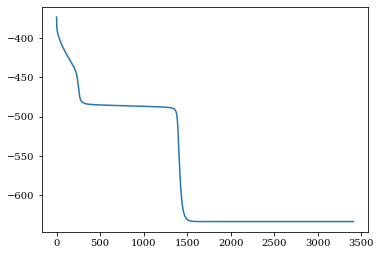

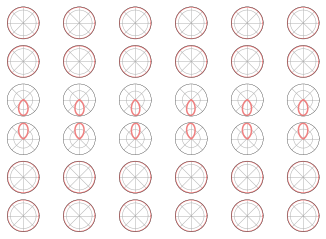

V_0 = 130 , iter step = 1
E = -446.8896743752039 , epsilon = 0.0028756101983240523 

V_0 = 130 , iter step = 2
E = -469.72992259217796 , epsilon = 0.001356550290179448 

V_0 = 130 , iter step = 3
E = -482.2481960375213 , epsilon = 0.0007002787449477132 

V_0 = 130 , iter step = 4
E = -489.8935050507746 , epsilon = 0.00039627485445015154 

V_0 = 130 , iter step = 5
E = -494.9896309223229 , epsilon = 0.00024323802907111336 

V_0 = 130 , iter step = 6
E = -498.62662592615743 , epsilon = 0.0001600488335041783 

V_0 = 130 , iter step = 7
E = -501.3633613450868 , epsilon = 0.00011168268721684083 

V_0 = 130 , iter step = 8
E = -503.50932884405063 , epsilon = 8.187340644860708e-05 

V_0 = 130 , iter step = 9
E = -505.2475522324751 , epsilon = 6.254636787961232e-05 

V_0 = 130 , iter step = 10
E = -506.69248207671967 , epsilon = 4.9450795046479534e-05 

V_0 = 130 , iter step = 11
E = -507.91917310466505 , epsilon = 4.0230484064762706e-05 

V_0 = 130 , iter step = 12
E = -508.978881758691 , eps

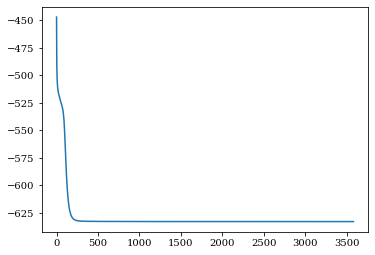

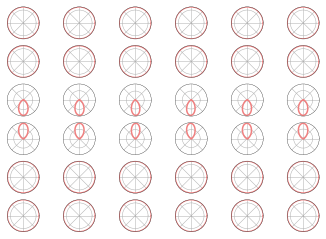

V_0 = 130 , iter step = 1
E = -655.6167754345925 , epsilon = 6.11521847393437e-05 

V_0 = 130 , iter step = 2
E = -656.3087329680313 , epsilon = 3.8311785900302375e-05 

V_0 = 130 , iter step = 3
E = -656.7732095616406 , epsilon = 2.4980544340191813e-05 

V_0 = 130 , iter step = 4
E = -657.0987583414101 , epsilon = 1.6899814220261433e-05 

V_0 = 130 , iter step = 5
E = -657.3349061218482 , epsilon = 1.1811716638998604e-05 

V_0 = 130 , iter step = 6
E = -657.5107210898284 , epsilon = 8.48948800835636e-06 

V_0 = 130 , iter step = 7
E = -657.6441567967283 , epsilon = 6.246966955836264e-06 

V_0 = 130 , iter step = 8
E = -657.7468672534335 , epsilon = 4.688028450994253e-06 

V_0 = 130 , iter step = 9
E = -657.8267638413654 , epsilon = 3.57635395931144e-06 

V_0 = 130 , iter step = 10
E = -657.8894229196159 , epsilon = 2.7662581763010508e-06 

V_0 = 130 , iter step = 11
E = -657.9388935787362 , epsilon = 2.16503247940647e-06 

V_0 = 130 , iter step = 12
E = -657.9781827347493 , epsilon = 

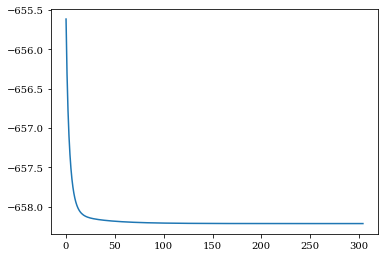

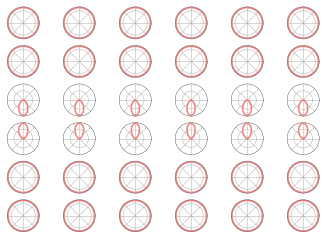

V_0 = 130 , iter step = 1
E = -284.0072917110825 , epsilon = 0.0007084232688909786 

V_0 = 130 , iter step = 2
E = -290.71765784864516 , epsilon = 0.00039967609628444034 

V_0 = 130 , iter step = 3
E = -294.9522127343997 , epsilon = 0.00023927155611258577 

V_0 = 130 , iter step = 4
E = -297.8740098741164 , epsilon = 0.00015354242789156203 

V_0 = 130 , iter step = 5
E = -300.0605850089537 , epsilon = 0.0001059137363479401 

V_0 = 130 , iter step = 6
E = -301.8102820960419 , epsilon = 7.832640048743844e-05 

V_0 = 130 , iter step = 7
E = -303.28458148973544 , epsilon = 6.165949004055538e-05 

V_0 = 130 , iter step = 8
E = -304.5753266913119 , epsilon = 5.1159712156079173e-05 

V_0 = 130 , iter step = 9
E = -305.73747578490173 , epsilon = 4.426693042625107e-05 

V_0 = 130 , iter step = 10
E = -306.8056251955605 , epsilon = 3.9557203994400325e-05 

V_0 = 130 , iter step = 11
E = -307.80264731303345 , epsilon = 3.621383525298505e-05 

V_0 = 130 , iter step = 12
E = -308.7443675054335 , ep

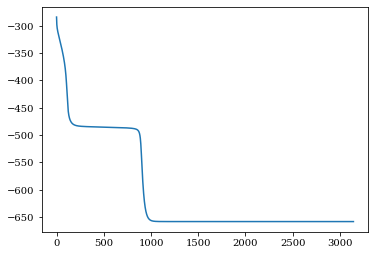

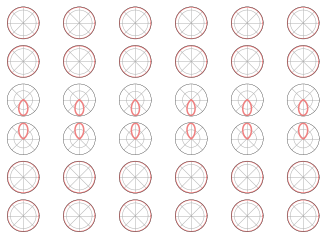

V_0 = 130 , iter step = 1
E = -446.9052492391854 , epsilon = 0.0028765638937507942 

V_0 = 130 , iter step = 2
E = -469.85423872143673 , epsilon = 0.0013633930499312719 

V_0 = 130 , iter step = 3
E = -482.5905883321755 , epsilon = 0.0007137249293640568 

V_0 = 130 , iter step = 4
E = -490.52840248123465 , epsilon = 0.0004138897134071673 

V_0 = 130 , iter step = 5
E = -495.9574312404474 , epsilon = 0.00026274520511160304 

V_0 = 130 , iter step = 6
E = -499.9451324108124 , epsilon = 0.0001799691847259588 

V_0 = 130 , iter step = 7
E = -503.0371864193104 , epsilon = 0.00013118343195550608 

V_0 = 130 , iter step = 8
E = -505.5359491257116 , epsilon = 0.0001005380597429717 

V_0 = 130 , iter step = 9
E = -507.6208983628677 , epsilon = 8.020442296263752e-05 

V_0 = 130 , iter step = 10
E = -509.4049847912703 , epsilon = 6.606961498722974e-05 

V_0 = 130 , iter step = 11
E = -510.96289736624124 , epsilon = 5.585060179569279e-05 

V_0 = 130 , iter step = 12
E = -512.3461363481415 , epsilo

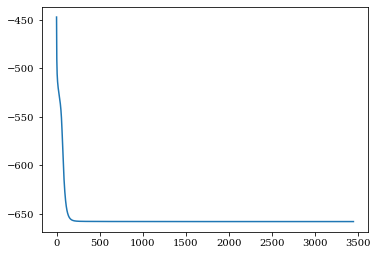

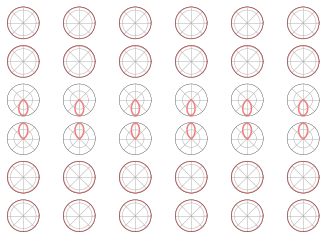

V_0 = 130 , iter step = 1
E = -664.5516358134349 , epsilon = 3.5903874956333404e-05 

V_0 = 130 , iter step = 2
E = -665.0355924985662 , epsilon = 2.5869544133860778e-05 

V_0 = 130 , iter step = 3
E = -665.3911408603248 , epsilon = 1.8939112555793614e-05 

V_0 = 130 , iter step = 4
E = -665.6574747898193 , epsilon = 1.4072041837120963e-05 

V_0 = 130 , iter step = 5
E = -665.8600584526399 , epsilon = 1.0598939717998412e-05 

V_0 = 130 , iter step = 6
E = -666.0160194688409 , epsilon = 8.082942069775889e-06 

V_0 = 130 , iter step = 7
E = -666.1372530544372 , epsilon = 6.234578212138686e-06 

V_0 = 130 , iter step = 8
E = -666.2322528367154 , epsilon = 4.859048586935977e-06 

V_0 = 130 , iter step = 9
E = -666.3072232658205 , epsilon = 3.823233077238086e-06 

V_0 = 130 , iter step = 10
E = -666.3667785400257 , epsilon = 3.0347884880654874e-06 

V_0 = 130 , iter step = 11
E = -666.4143974302197 , epsilon = 2.428728090309029e-06 

V_0 = 130 , iter step = 12
E = -666.4527295944317 , epsil

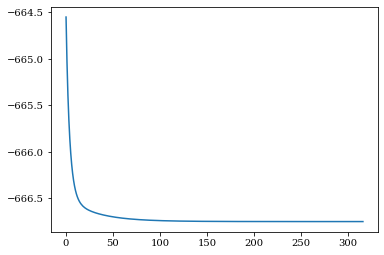

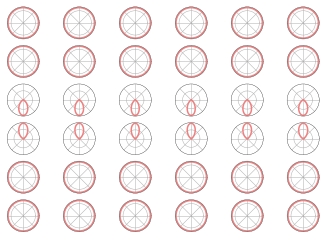

V_0 = 130 , iter step = 1
E = -189.7496516076967 , epsilon = 0.0007467216044523273 

V_0 = 130 , iter step = 2
E = -197.00874239481175 , epsilon = 0.0004326431913597162 

V_0 = 130 , iter step = 3
E = -201.74346012956397 , epsilon = 0.00026828186540250876 

V_0 = 130 , iter step = 4
E = -205.13423401444732 , epsilon = 0.0001797839548026703 

V_0 = 130 , iter step = 5
E = -207.77016983816458 , epsilon = 0.0001302192597227858 

V_0 = 130 , iter step = 6
E = -209.95722543849715 , epsilon = 0.00010126372797447658 

V_0 = 130 , iter step = 7
E = -211.86204344650292 , epsilon = 8.362301097641911e-05 

V_0 = 130 , iter step = 8
E = -213.58011294595894 , epsilon = 7.24322313386816e-05 

V_0 = 130 , iter step = 9
E = -215.16907745554502 , epsilon = 6.505840034387589e-05 

V_0 = 130 , iter step = 10
E = -216.66559368373962 , epsilon = 6.0028884981910835e-05 

V_0 = 130 , iter step = 11
E = -218.0941761704614 , epsilon = 5.649363691095921e-05 

V_0 = 130 , iter step = 12
E = -219.4720060503405 , 

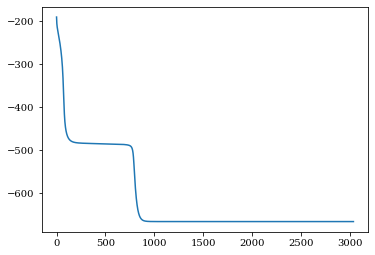

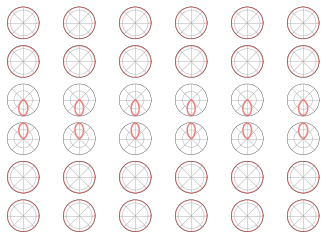

V_0 = 130 , iter step = 1
E = -446.91170051670684 , epsilon = 0.002876958925082329 

V_0 = 130 , iter step = 2
E = -469.905727489277 , epsilon = 0.0013662271092584888 

V_0 = 130 , iter step = 3
E = -482.73237163953934 , epsilon = 0.0007192919815982579 

V_0 = 130 , iter step = 4
E = -490.7912587586593 , epsilon = 0.0004211792834054595 

V_0 = 130 , iter step = 5
E = -496.3580892424807 , epsilon = 0.00027081647799320763 

V_0 = 130 , iter step = 6
E = -500.4910801386549 , epsilon = 0.00018821629328769074 

V_0 = 130 , iter step = 7
E = -503.73060233353544 , epsilon = 0.0001392708359512218 

V_0 = 130 , iter step = 8
E = -506.3762116240697 , epsilon = 0.00010830291438557182 

V_0 = 130 , iter step = 9
E = -508.60605532260496 , epsilon = 8.75846029796401e-05 

V_0 = 130 , iter step = 10
E = -510.5325786611787 , epsilon = 7.305841236471267e-05 

V_0 = 130 , iter step = 11
E = -512.2304152577422 , epsilon = 6.246997655479092e-05 

V_0 = 130 , iter step = 12
E = -513.7512485842852 , epsilon

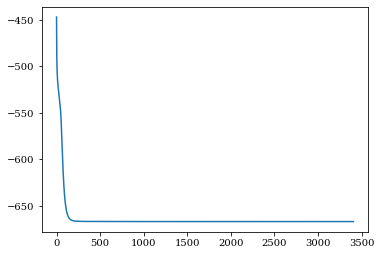

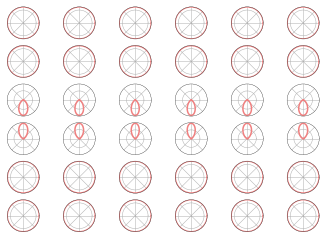

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


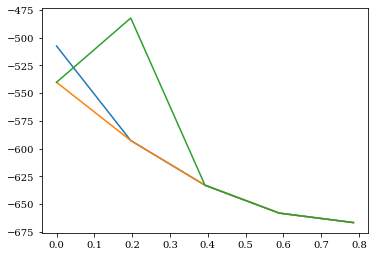

In [56]:
delta_scan = np.linspace(0,np.pi/4,5) #np.array([10,50,90,130,170])
params["tol"] = 1e-11
params["V_0"] = 130

E_domain_wall_v = np.zeros(len(delta_scan), dtype=complex)
E_domain_wall_h = np.zeros(len(delta_scan), dtype=complex)
E_ferro_order = np.zeros(len(delta_scan), dtype=complex)

i = 0
for delta in delta_scan:
    params["angle_pattern"] = [-delta,delta,delta,-delta]

    ''' 
    Time evolve domain wall
    '''
    params["init_choice"] = 'ferro_domain_horizontal_wall'
    psi_out_control, E_conv_control_ferro_domain_h = solve_imag_time_prop(params)

    plt.plot(E_conv_control_ferro_domain_h); plt.show()
    plot_rotor_wavefunction(x, My, Mx, psi_out_control.real); plt.show()

    ''' 
    Time evolve domain wall vertical
    '''
    params["init_choice"] = 'ferro_domain_vertical_wall'
    psi_out_control, E_conv_control_ferro_domain_v = solve_imag_time_prop(params)

    plt.plot(E_conv_control_ferro_domain_v); plt.show()
    plot_rotor_wavefunction(x, My, Mx, psi_out_control.real); plt.show()

    ''' 
    Time evolve ferro order
    '''
    params["init_choice"] = 'uniform'
    psi_out_control, E_conv_control_ferro_order = solve_imag_time_prop(params)

    plt.plot(E_conv_control_ferro_order); plt.show()
    plot_rotor_wavefunction(x, My, Mx, psi_out_control.real); plt.show()

    E_domain_wall_v[i] = E_conv_control_ferro_domain_v[-1]
    E_domain_wall_h[i] = E_conv_control_ferro_domain_h[-1]
    E_ferro_order[i] = E_conv_control_ferro_order[-1]

    i += 1

plt.plot(delta_scan, E_ferro_order)
plt.plot(delta_scan, E_domain_wall_h)
plt.plot(delta_scan, E_domain_wall_v)
plt.show()

[0.         0.19634954 0.39269908 0.58904862 0.78539816]
[-507.5449682 +0.j -592.77967974+0.j -633.06356132+0.j -658.21209761+0.j
 -666.75057659+0.j]
[-540.25308185+0.j -592.77992416+0.j -633.06381175+0.j -658.21234214+0.j
 -666.75082065+0.j]
[-540.25308185+0.j -482.3040027 +0.j -633.06356201+0.j -658.21209625+0.j
 -666.75057486+0.j]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


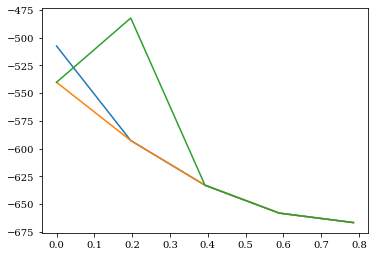

In [57]:
plt.plot(delta_scan, E_ferro_order)
plt.plot(delta_scan, E_domain_wall_h)
plt.plot(delta_scan, E_domain_wall_v)
print(delta_scan)
print(E_ferro_order)
print(E_domain_wall_h)
print(E_domain_wall_v)
plt.show()

### 2nd: symmetric contraction

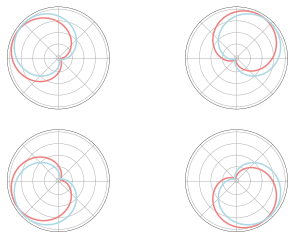

In [ ]:
delta = np.pi/10
params["angle_pattern"] = [-delta,-delta,delta,delta]
params["init_choice"] = 'ferro_domain_horizontal_wall'
params["tol"] = 1e-7

'''
Visualize
'''
angle_pattern = np.array(params["angle_pattern"])
visualize_angle_pattern(x, angle_pattern)

V_0 = 150.0 , iter step = 1
E = -563.2925058390413 , epsilon = 0.0008104325203660556 

V_0 = 150.0 , iter step = 2
E = -568.1615255168922 , epsilon = 0.0004899648024431213 

V_0 = 150.0 , iter step = 3
E = -571.2208790255654 , epsilon = 0.0003103200609690937 

V_0 = 150.0 , iter step = 4
E = -573.3019231294479 , epsilon = 0.00020632854140634205 

V_0 = 150.0 , iter step = 5
E = -574.8232497536129 , epsilon = 0.00014377606433546575 

V_0 = 150.0 , iter step = 6
E = -576.0042626808402 , epsilon = 0.00010465021306360622 

V_0 = 150.0 , iter step = 7
E = -576.9655256117005 , epsilon = 7.923621467909037e-05 

V_0 = 150.0 , iter step = 8
E = -577.7767538049754 , epsilon = 6.212911066250104e-05 

V_0 = 150.0 , iter step = 9
E = -578.4804337688947 , epsilon = 5.0222741091343615e-05 

V_0 = 150.0 , iter step = 10
E = -579.1038329290831 , epsilon = 4.167481472561185e-05 

V_0 = 150.0 , iter step = 11
E = -579.6653195663366 , epsilon = 3.5359469935603016e-05 

V_0 = 150.0 , iter step = 12
E = -58

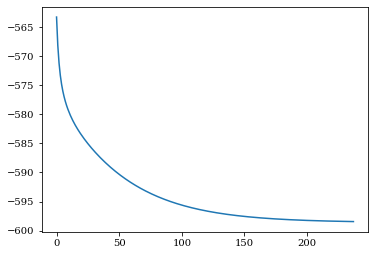

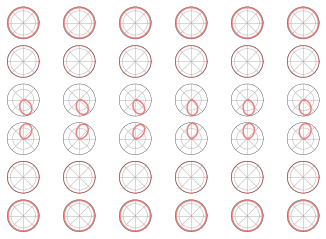

In [ ]:
''' 
Time evolve
'''
psi_out_control, E_conv_control = solve_imag_time_prop(params)

plt.plot(E_conv_control)
plot_rotor_wavefunction(x, My, Mx, psi_out_control.real)

V_0 = 150.0 , iter step = 1
E = -575.8761255358957 , epsilon = 0.0009319990063474393 

V_0 = 150.0 , iter step = 2
E = -582.3019878317929 , epsilon = 0.0005222556355821695 

V_0 = 150.0 , iter step = 3
E = -586.0490975095146 , epsilon = 0.0003055737601076469 

V_0 = 150.0 , iter step = 4
E = -588.3959262692592 , epsilon = 0.00018722616445987494 

V_0 = 150.0 , iter step = 5
E = -589.9675111891371 , epsilon = 0.00011995385552299176 

V_0 = 150.0 , iter step = 6
E = -591.0830180901971 , epsilon = 8.014548790635789e-05 

V_0 = 150.0 , iter step = 7
E = -591.9137165647826 , epsilon = 5.5672285270036426e-05 

V_0 = 150.0 , iter step = 8
E = -592.5563989864171 , epsilon = 4.00810939104046e-05 

V_0 = 150.0 , iter step = 9
E = -593.0687031954343 , epsilon = 2.981370143007034e-05 

V_0 = 150.0 , iter step = 10
E = -593.486758146895 , epsilon = 2.2840402895907275e-05 

V_0 = 150.0 , iter step = 11
E = -593.8343380882717 , epsilon = 1.7966277974235112e-05 

V_0 = 150.0 , iter step = 12
E = -594.

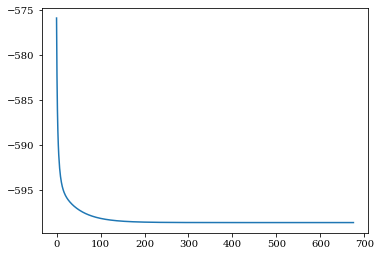

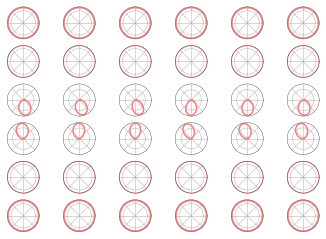

In [ ]:
delta = np.pi/20
params["angle_pattern"] = [-delta,-delta,-delta,-delta]
params["init_choice"] = 'ferro_domain_horizontal_wall'

'''
Visualize
'''
angle_pattern = np.array(params["angle_pattern"])
visualize_angle_pattern(x, angle_pattern)

''' 
Time evolve
'''
psi_out_horiz, E_conv_horiz = solve_imag_time_prop(params)

plt.plot(E_conv_horiz)
plot_rotor_wavefunction(x, My, Mx, psi_out_horiz.real)

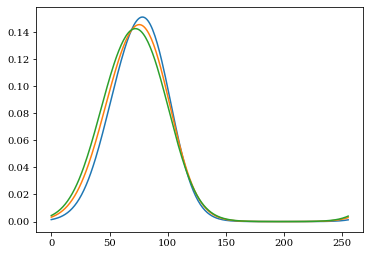

In [ ]:
plt.plot(psi_out_horiz[0,0].real)
plt.plot(psi_out_horiz[0,1].real)
plt.plot(psi_out_horiz[0,2].real)

In [ ]:
energy_object = energy.energy(params=params)
E, E_T, E_B, E_V = energy_object.calc_energy(psi_out_horiz)
print('E =', E)

E = (-593.1785254921851+8.228536555842845e-17j)


E12 = (-593.1785254921895+8.228536270968778e-17j)
S12 = (0.8323145507212237+1.1841767299468492e-16j)
[[-593.17852549+8.22853627e-17j -497.57952518+2.66499749e-12j]
 [-497.57952518-2.66515741e-12j -598.61041496-7.86045960e-17j]]
[[1.        +0.00000000e+00j 0.83231455+1.18417673e-16j]
 [0.83231455-1.18417673e-16j 1.        +0.00000000e+00j]]
|H| max = 598.610414956381
[-598.70776141 -584.36998726]
[ 0.13153391+5.66998352e-13j -0.99131167-5.76434877e-13j]


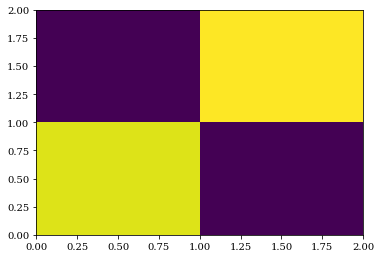

In [ ]:
q = np.array([0,0])
coupl_object = energy.coupling_of_states(params=params)
E12, E12_T, E12_B, E12_V = coupl_object.calc_hamiltonian_matrix_element(psi_out_horiz, q, psi_out_horiz, q)
S12 = coupl_object.calc_overlap(psi_out_horiz, psi_out_control)

print('E12 =', E12)
print('S12 =', S12)

psi_arr = [psi_out_horiz, psi_out_control]
q_arr = [q,q]

heff, s_ove = coupl_object.calc_hamiltonian(2, psi_arr, q_arr)
evals, ekets, tra = coupl_object.diag_hamiltonian(heff, s_ove)

plt.pcolormesh(np.abs(heff))
print(heff)
print(s_ove)
print('|H| max =', np.max(np.abs(heff)))
print(evals)
print(ekets[:,0])

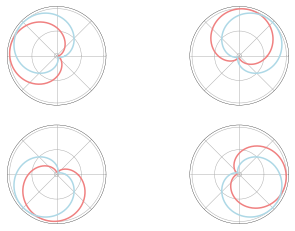